In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import yfinance as yf
from Classes import Data
from Classes import Sortino

# CPO

### Carga de datos

### Si deseas usar otras fechas usa el siguiente bloque:

In [2]:
data = Data()
data.dates("2024-12-15", "2025-01-01") 
data.sp500()
df_prices = data.prices()
df_random = data.random(df_prices, num=15)
df_rend = data.returns(df_random)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [3]:
model= data.select_model(df_random.columns.tolist())
model

1

In [7]:
data = Data()
data.dates("2010-01-01", "2025-01-01")
df_prices = data.load_prices_from_csv("prices.csv")
g1 = df_prices.iloc[:, 0:30]    # Primeros 30
g2 = df_prices.iloc[:, 30:65]   # Tickers 31-65
g3 = df_prices.iloc[:, 65:100]  # Tickers 66-100
df1 = data.random(grupo1, num=15)
df2 = data.random(grupo2, num=15)
df3 = data.random(grupo3, num=15)
df_rend1 = data.returns(df1)
df_rend2 = data.returns(df2)
df_rend3 = data.returns(df3)

C:\Users\rania\OneDrive\Documentos\GitHub\New_CPO\Classes.py:99: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')


### Sortino Data Frame

In [8]:
sortino1 = Sortino(returns_df=df_rend1,rfr_csv_path="rfr.csv")
sortino1.generate_multiple_weights()
sortino1.calculate_portfolio_returns()
sortino1.calculate_sortino_ratio()

Generadas 1000 combinaciones de pesos para cada fecha.
Rendimientos del portafolio calculados para cada combinación de pesos.
Ratios de Sortino calculados para cada combinación de pesos.


In [10]:
dfsortino1 = sortino1.create_portfolio_dataset()
dfsortino1

,Date,Weight_AOS,Weight_APD,Weight_A,Weight_AMCR,Weight_ABBV,Weight_ALLE,Weight_AEP,Weight_AEE,Weight_AMT,Weight_MMM,Weight_MO,Weight_AMP,Weight_GOOG,Weight_AIG,Weight_ALB,Portfolio_Returns,Sortino_Ratio
0,2010-02-28,7.649414,9.307955,11.140568,9.348149,6.302322,5.230585,2.063385,6.793274,1.257612,13.586773,2.144681,11.730759,10.257985,0.819921,2.366618,NaN,NaN
1,2010-02-28,5.215332,4.926266,4.244629,12.174834,2.572801,9.674702,12.522501,3.960998,11.847900,4.098221,3.188624,4.308944,8.750982,2.108571,10.404695,NaN,NaN
2,2010-02-28,13.537765,13.667248,2.049316,2.239218,0.339991,2.651315,0.599895,2.431194,14.995021,8.181281,15.613330,13.080554,3.539186,0.678452,6.396236,NaN,NaN
3,2010-02-28,4.288626,11.314048,5.300240,4.341383,9.337353,8.484008,6.617936,3.660701,7.401951,3.028984,11.767989,7.301129,6.576097,7.741358,2.838198,NaN,NaN
4,2010-02-28,15.824482,13.883337,0.211080,6.009078,3.268984,9.645193,7.562068,10.862180,0.437192,12.489646,9.538433,4.938227,1.525605,3.010954,0.793540,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154995,2022-12-31,10.973837,3.210401,6.926863,7.437257,5.337325,4.121714,5.562480,11.967138,5.244803,6.034323,10.445537,6.737071,9.831744,0.741313,5.428196,-0.047880,-1.555680
154996,2022-12-31,1.700824,9.297969,10.222125,6.753343,3.787270,8.883694,5.795194,13.562813,4.388073,1.212143,7.547534,0.190936,11.702847,2.923740,12.031495,-0.056998,-1.850972
154997,2022-12-31,11.111898,1.153009,0.657136,4.438845,8.490589,11.002608,7.601405,8.508909,12.353015,10.012940,3.165783,7.043405,9.216261,4.172471,1.071724,-0.044459,-1.444892
154998,2022-12-31,2.849090,5.671518,17.567962,3.500871,8.337250,3.227420,3.957176,7.842670,0.954377,10.449454,1.485361,4.175354,12.151395,7.434943,10.395160,-0.056823,-1.845311


In [11]:
sortino2 = Sortino(returns_df=df_rend2,rfr_csv_path="rfr.csv")
sortino2.generate_multiple_weights()
sortino2.calculate_portfolio_returns()
sortino2.calculate_sortino_ratio()

Generadas 1000 combinaciones de pesos para cada fecha.
Rendimientos del portafolio calculados para cada combinación de pesos.
Ratios de Sortino calculados para cada combinación de pesos.


In [12]:
dfsortino2 = sortino2.create_portfolio_dataset()
dfsortino2

,Date,Weight_APH,Weight_ANET,Weight_ADSK,Weight_BALL,Weight_ADP,Weight_ADM,Weight_AMGN,Weight_APA,Weight_AJG,Weight_BDX,Weight_TECH,Weight_BK,Weight_AVB,Weight_BIIB,Weight_ANSS,Portfolio_Returns,Sortino_Ratio
0,2010-02-28,7.706386,8.021198,5.412741,1.409658,7.445566,0.716591,10.365884,11.658496,11.825097,3.423163,9.670107,8.945912,4.066694,7.549352,1.783157,NaN,NaN
1,2010-02-28,0.699996,14.669214,11.675942,13.102972,8.082962,8.153420,7.897966,0.596908,13.859435,0.166726,8.896954,2.933302,3.319587,2.782817,3.161799,NaN,NaN
2,2010-02-28,5.000284,12.145627,4.397264,8.618225,2.671792,4.193052,10.837869,0.184669,8.279456,4.579988,4.451254,6.347130,9.656309,7.489519,11.147560,NaN,NaN
3,2010-02-28,7.494438,10.056020,7.243638,3.871381,3.318930,8.733941,10.907815,6.219671,6.602678,2.970433,5.239633,1.101510,8.861630,7.482742,9.895540,NaN,NaN
4,2010-02-28,15.839671,1.303269,0.866315,6.143748,2.274619,11.752830,6.771106,10.166716,9.270764,0.863789,13.861491,2.419637,15.687115,0.350359,2.428572,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154995,2022-12-31,2.080746,4.121329,3.241749,10.212308,1.590852,9.048999,7.444870,10.651989,0.819229,5.025772,8.192714,6.968413,13.457676,12.792158,4.351196,-0.055024,-1.606367
154996,2022-12-31,13.160659,4.964868,0.906559,3.159657,3.353773,2.589978,3.317137,15.374084,15.546816,0.576866,4.263529,0.244619,11.849662,14.232285,6.459508,-0.057343,-1.673865
154997,2022-12-31,7.552373,5.046145,1.340332,5.659790,8.736844,15.703544,1.188823,0.636838,3.801144,7.788254,13.189758,1.220076,14.553392,10.801882,2.780805,-0.057441,-1.676737
154998,2022-12-31,10.658907,11.312613,4.600172,4.850605,11.404699,4.459703,1.821790,6.540843,0.236889,10.662185,7.850716,6.268671,9.252833,3.517607,6.561765,-0.054814,-1.600265


In [13]:
sortino3 = Sortino(returns_df=df_rend3,rfr_csv_path="rfr.csv")
sortino3.generate_multiple_weights()
sortino3.calculate_portfolio_returns()
sortino3.calculate_sortino_ratio()

Generadas 1000 combinaciones de pesos para cada fecha.
Rendimientos del portafolio calculados para cada combinación de pesos.
Ratios de Sortino calculados para cada combinación de pesos.


In [14]:
dfsortino3 = sortino3.create_portfolio_dataset()
dfsortino3

,Date,Weight_CPB,Weight_BLDR,Weight_CNC,Weight_BMY,Weight_CRL,Weight_COR,Weight_AVGO,Weight_BG,Weight_BRO,Weight_BR,Weight_CZR,Weight_CAT,Weight_BWA,Weight_KMX,Weight_BXP,Portfolio_Returns,Sortino_Ratio
0,2010-02-28,3.056263,13.764505,3.425549,7.325337,3.101617,13.700797,3.882529,2.572408,2.858552,2.663767,7.875150,7.927216,14.428839,2.885779,10.531689,NaN,NaN
1,2010-02-28,3.807016,13.012873,13.172537,0.620495,8.029817,8.058982,11.486463,1.591123,0.808118,5.851082,4.377641,12.640319,8.790102,6.813197,0.940234,NaN,NaN
2,2010-02-28,5.034141,5.386702,9.942212,6.516695,8.247679,3.569200,11.283566,0.293538,6.641857,9.302562,2.642766,9.329597,7.165594,9.114157,5.529737,NaN,NaN
3,2010-02-28,5.669602,5.779723,1.296616,6.121149,13.221233,0.091441,10.772740,12.631313,3.860587,4.478735,11.121415,1.606635,1.328279,9.380168,12.640364,NaN,NaN
4,2010-02-28,7.862482,0.583880,9.474414,3.776135,0.050816,10.812886,12.347171,8.335361,9.619627,8.832408,6.558473,11.018078,1.616712,5.183028,3.928528,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154995,2022-12-31,2.435705,9.400632,2.687032,10.171879,0.082188,12.062653,11.183696,1.959898,8.324022,3.210746,13.397007,4.969654,10.374278,6.821902,2.918708,-0.056850,-1.359639
154996,2022-12-31,9.479531,6.267787,9.421796,8.692130,8.748013,7.160683,0.519887,5.712873,7.900687,8.391251,5.517513,10.486091,0.090555,4.600259,7.010944,-0.046104,-1.103327
154997,2022-12-31,11.091805,7.473250,6.655957,5.857266,9.651250,0.761089,3.643772,5.434302,4.422393,9.149211,2.998487,6.252610,6.960493,9.310589,10.337526,-0.044362,-1.061789
154998,2022-12-31,3.715064,2.025245,0.695712,10.293405,17.405302,6.941271,9.584889,1.071672,8.684474,12.407312,10.161182,8.594199,2.373221,2.783048,3.264003,-0.056334,-1.347324


In [16]:
dfsortino1.to_csv('dfsortino1.csv')
dfsortino2.to_csv('dfsortino2.csv')
dfsortino3.to_csv('dfsortino3.csv')

In [4]:
dataset_merged = pd.read_csv('Data_Base/dataset_merged.csv')
sampling_data = pd.read_csv('Sampling_data.csv')

In [6]:
dataset_merged.describe()

,Unnamed: 0,"Weight_('BALL', 'BALL')","Weight_('BSX', 'BSX')","Weight_('CZR', 'CZR')","Weight_('AEP', 'AEP')","Weight_('ARE', 'ARE')","Weight_('ABT', 'ABT')","Weight_('BLDR', 'BLDR')","Weight_('GOOG', 'GOOG')","Weight_('MO', 'MO')",...,WTI index,Dollar index,TRCCRB,BCI,CCI,CLI,GPRI,Unemployment rate,Portfolio_Returns,Sortino_Ratio
count,179000.00000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,...,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,123000.000000,123000.000000
mean,89499.50000,6.659674,6.658353,6.665573,6.669224,6.656715,6.682044,6.670020,6.662237,6.671269,...,0.005698,0.002291,0.001006,100.222772,99.545419,100.222772,2.295196,5.775978,0.014439,0.439851
std,51672.99343,3.844111,3.841827,3.842968,3.838186,3.847300,3.843388,3.839821,3.843072,3.839530,...,0.116004,0.021554,0.047697,0.883412,1.106564,0.883412,0.740032,2.216635,0.048961,1.498609
min,0.00000,0.000028,0.000123,0.000492,0.000045,0.000047,0.000046,0.000080,0.000031,0.000050,...,-0.540000,-0.050000,-0.240000,96.761450,96.624510,96.761450,1.250000,3.400000,-0.242180,-7.414095
25%,44749.75000,3.446605,3.445169,3.443461,3.462400,3.429395,3.473962,3.457859,3.444670,3.450228,...,-0.060000,-0.010000,-0.030000,99.582950,98.877400,99.582950,1.760000,3.900000,-0.013353,-0.410358
50%,89499.50000,6.654430,6.645424,6.670457,6.661126,6.646412,6.671420,6.673814,6.654035,6.687503,...,0.010000,0.000000,0.000000,100.177400,99.504150,100.177400,2.110000,5.000000,0.017690,0.539749
75%,134249.25000,9.679254,9.670872,9.685147,9.675801,9.660931,9.704938,9.682952,9.684421,9.685547,...,0.060000,0.020000,0.030000,100.784900,100.514900,100.784900,2.690000,7.500000,0.045073,1.377038
max,178999.00000,27.155056,24.022641,27.838829,27.137399,26.216470,23.993981,26.728226,24.021959,24.479848,...,0.880000,0.070000,0.130000,102.061700,101.183400,102.061700,6.900000,14.800000,0.246018,7.531536


In [11]:
sampling_data.describe()

,Unnamed: 0,"Weight_('BALL', 'BALL')","Weight_('BSX', 'BSX')","Weight_('CZR', 'CZR')","Weight_('AEP', 'AEP')","Weight_('ARE', 'ARE')","Weight_('ABT', 'ABT')","Weight_('BLDR', 'BLDR')","Weight_('GOOG', 'GOOG')","Weight_('MO', 'MO')",...,WTI index,Dollar index,TRCCRB,BCI,CCI,CLI,GPRI,Unemployment rate,Portfolio_Returns,Sortino_Ratio
count,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,...,36200.00,36200.00,3.620000e+04,3.620000e+04,3.620000e+04,3.620000e+04,3.620000e+04,3.620000e+04,36200.000000,36200.000000
mean,56090.000000,6.877998,6.893875,6.347055,6.395892,6.544488,6.923403,6.567539,6.371105,6.522182,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.050068,1.532788
std,52.250124,3.826923,3.642740,3.901985,3.884581,4.004338,3.490745,3.818005,3.954274,4.012539,...,0.00,0.00,1.110238e-16,1.421105e-14,2.842210e-14,1.421105e-14,2.220477e-16,1.776381e-15,0.010014,0.306581
min,56000.000000,0.114853,0.076915,0.038760,0.012865,0.036449,0.054632,0.028081,0.018887,0.063588,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.024527,0.750871
25%,56045.000000,3.881524,4.098672,2.836147,3.260928,2.877356,4.304482,3.353213,2.793953,3.380585,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.043295,1.325445
50%,56090.000000,6.591996,6.964783,6.082038,6.497772,7.212210,7.394765,6.388311,6.533260,6.732725,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.050423,1.543656
75%,56135.000000,9.853152,9.512524,9.670696,9.039570,9.448945,9.634104,9.668159,9.611395,9.837269,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.056935,1.743041
max,56180.000000,15.960789,16.853355,15.300434,21.330791,17.769886,14.629643,18.376732,19.554063,19.954894,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.075765,2.319502


# Training ML models

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# For models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from Classes import BasePortfolioModel, LinearRegressionModel, NeuralNetworkModel, XGBoostModel, SVRModel

Training Linear Regression Model...
Linear Regression model fitted.
Evaluation -- MSE: 1.6632, R2: 0.2599

Training Neural Network Model...


/Users/alexsotomayor/code/PAP/New_CPO/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network model trained.
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation -- MSE: 0.0348, R2: 0.9845

Training SVR Model...
SVR model fitted.
Evaluation -- MSE: 1.8244, R2: 0.1882

Training XGBoost Model...
XGBoost model fitted.
Evaluation -- MSE: 0.3220, R2: 0.8567
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


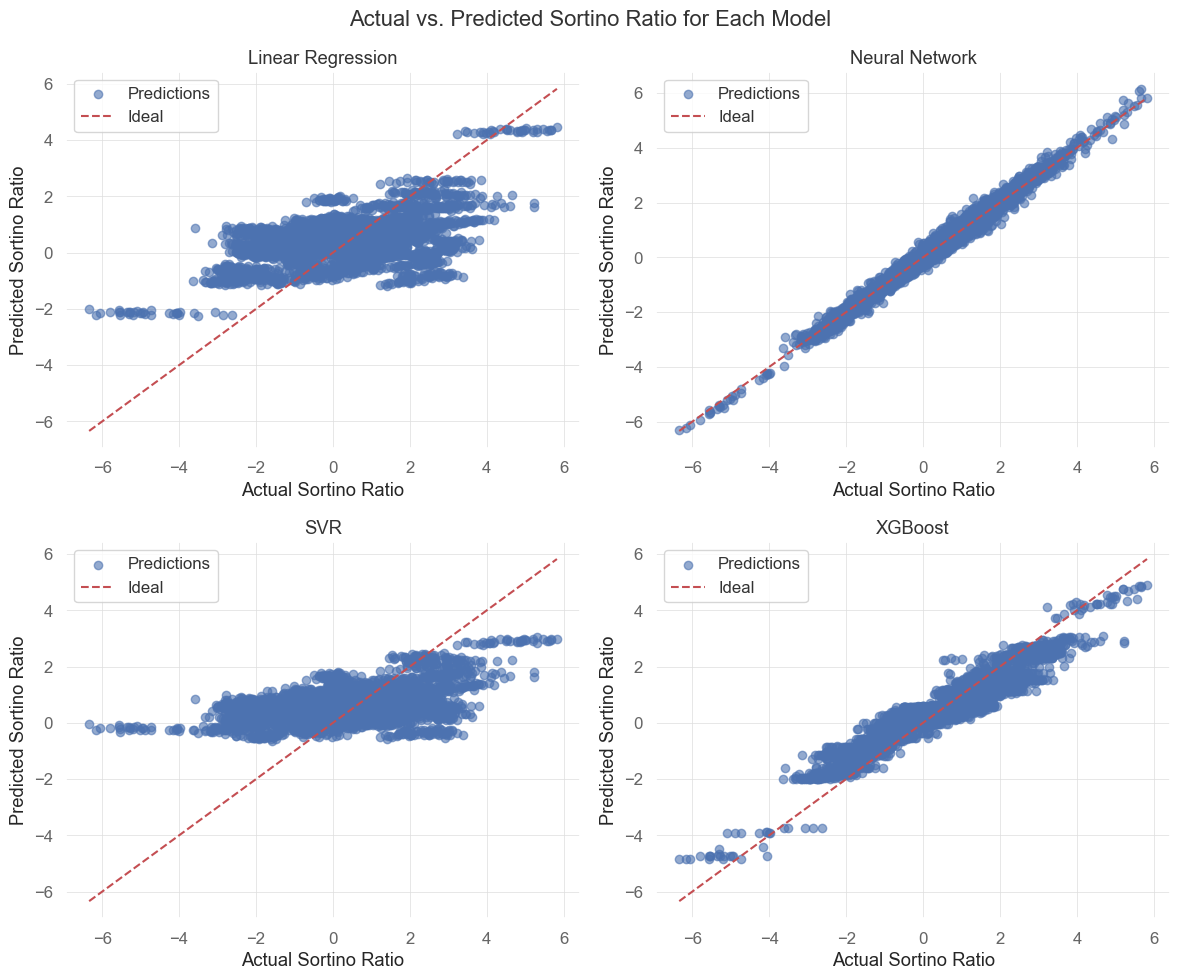

In [31]:
def plot_model_results(models, X_test, y_test):

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for ax, (name, model) in zip(axes, models.items()):
        preds = model.predict(X_test)
        ax.scatter(y_test, preds, alpha=0.6, label='Predictions')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
        ax.set_xlabel("Actual Sortino Ratio")
        ax.set_ylabel("Predicted Sortino Ratio")
        ax.set_title(name)
        ax.legend()

    fig.suptitle("Actual vs. Predicted Sortino Ratio for Each Model")
    plt.tight_layout()
    plt.show()


def main():
    # Cargar datos
    df = pd.read_csv('sampled_data.csv')
    
    # Dividir entre X e y
    X = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    
    # Train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {}
    
    print("Training Linear Regression Model...")
    lr_model = LinearRegressionModel()
    lr_model.fit(X_train, y_train)
    lr_model.evaluate(X_test, y_test)
    models["Linear Regression"] = lr_model
    
    print("\nTraining Neural Network Model...")
    nn_model = NeuralNetworkModel(input_dim=X.shape[1], hidden_units=64, epochs=100)
    nn_model.fit(X_train, y_train)
    nn_model.evaluate(X_test, y_test)
    models["Neural Network"] = nn_model
    
    print("\nTraining SVR Model...")
    svr_model = SVRModel(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    svr_model.evaluate(X_test, y_test)
    models["SVR"] = svr_model
    
    print("\nTraining XGBoost Model...")
    xgb_model = XGBoostModel(n_estimators=100, max_depth=4, learning_rate=0.05)
    xgb_model.fit(X_train, y_train)
    xgb_model.evaluate(X_test, y_test)
    models["XGBoost"] = xgb_model

    # Graficar resultados para mejor visualización
    plot_model_results(models, X_test, y_test)
    

if __name__ == "__main__":
    main()

# Part 3. Testing ML Models tuned and with 3 different datasets.

2025-03-18 21:33:40.479764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Processing Dataset_1...

Training Linear Regression Model...
Linear Regression model fitted.
Evaluation -- MSE: 1.8270, R2: 0.2330

Training Neural Network Model...
Neural Network model trained.
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation -- MSE: 0.0791, R2: 0.9668

Training SVR Model...
SVR model fitted.
Evaluation -- MSE: 0.1001, R2: 0.9580

Training XGBoost Model...
 XGBoost optimizado entrenado con éxito.
Evaluation -- MSE: 0.1101, R2: 0.9538
Saved Linear Regression model to Dataset_1_Linear Regression.pkl
Saved Neural Network model to Dataset_1_Neural Network.pkl
Saved SVR model to Dataset_1_SVR.pkl
Saved XGBoost model to Dataset_1_XGBoost.pkl

Final evaluation on test set for Dataset_1:

Linear Regression Model:
Evaluation -- MSE: 1.8125, R2: 0.2247

Neural Network Model:
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation -- MSE: 0.0794, R2: 0.9660

SVR Model:
Evaluation -- MSE: 0.1008, R2: 0.9569

XGBoost Model:
Evaluation -- MSE: 0.1070, R2: 0.9542
185/185 ━━━━━━━━━━━

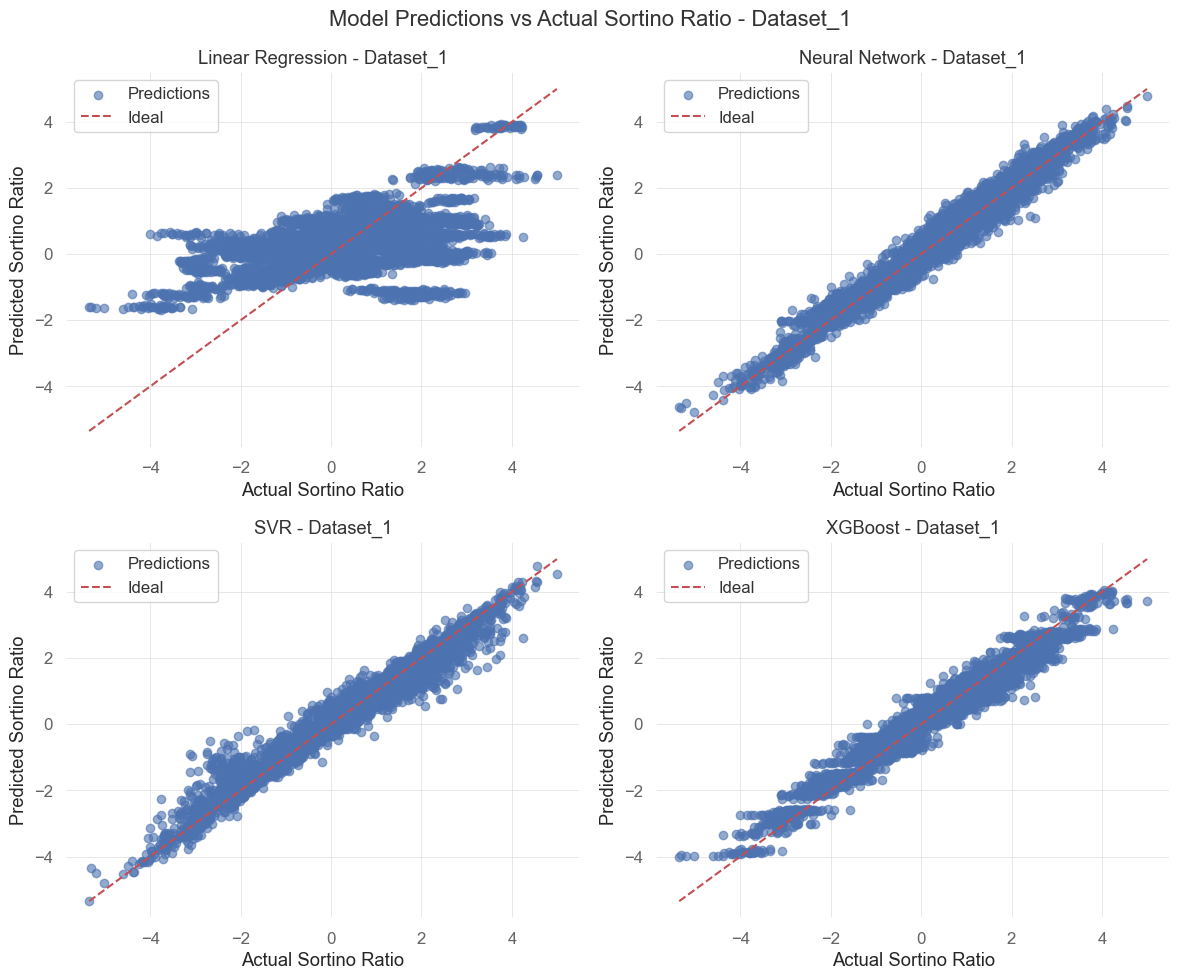


Processing Dataset_2...

Training Linear Regression Model...
Linear Regression model fitted.
Evaluation -- MSE: 1.4311, R2: 0.2859

Training Neural Network Model...
Neural Network model trained.
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation -- MSE: 0.0846, R2: 0.9578

Training SVR Model...
SVR model fitted.
Evaluation -- MSE: 0.0771, R2: 0.9615

Training XGBoost Model...
 XGBoost optimizado entrenado con éxito.
Evaluation -- MSE: 0.1033, R2: 0.9485
Saved Linear Regression model to Dataset_2_Linear Regression.pkl
Saved Neural Network model to Dataset_2_Neural Network.pkl
Saved SVR model to Dataset_2_SVR.pkl
Saved XGBoost model to Dataset_2_XGBoost.pkl

Final evaluation on test set for Dataset_2:

Linear Regression Model:
Evaluation -- MSE: 1.4182, R2: 0.2772

Neural Network Model:
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation -- MSE: 0.0848, R2: 0.9568

SVR Model:
Evaluation -- MSE: 0.0769, R2: 0.9608

XGBoost Model:
Evaluation -- MSE: 0.0971, R2: 0.9505
185/185 ━━━━━━━━━━━

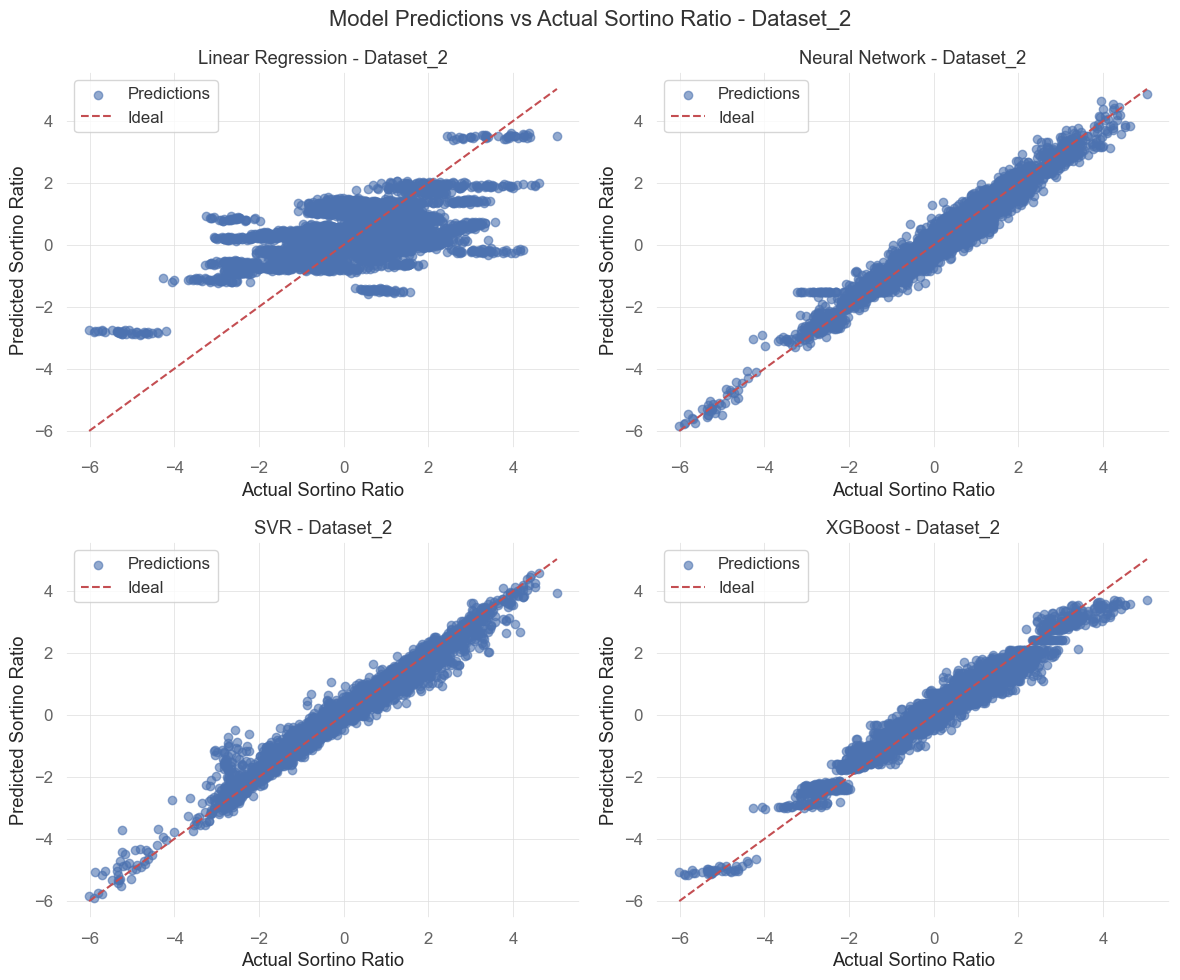


Processing Dataset_3...

Training Linear Regression Model...
Linear Regression model fitted.
Evaluation -- MSE: 1.1583, R2: 0.3224

Training Neural Network Model...
Neural Network model trained.
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation -- MSE: 0.0639, R2: 0.9626

Training SVR Model...
SVR model fitted.
Evaluation -- MSE: 0.0537, R2: 0.9686

Training XGBoost Model...
 XGBoost optimizado entrenado con éxito.
Evaluation -- MSE: 0.0690, R2: 0.9597
Saved Linear Regression model to Dataset_3_Linear Regression.pkl
Saved Neural Network model to Dataset_3_Neural Network.pkl
Saved SVR model to Dataset_3_SVR.pkl
Saved XGBoost model to Dataset_3_XGBoost.pkl

Final evaluation on test set for Dataset_3:

Linear Regression Model:
Evaluation -- MSE: 1.1511, R2: 0.3628

Neural Network Model:
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation -- MSE: 0.0684, R2: 0.9621

SVR Model:
Evaluation -- MSE: 0.0534, R2: 0.9704

XGBoost Model:
Evaluation -- MSE: 0.0680, R2: 0.9624
173/173 ━━━━━━━━━━━

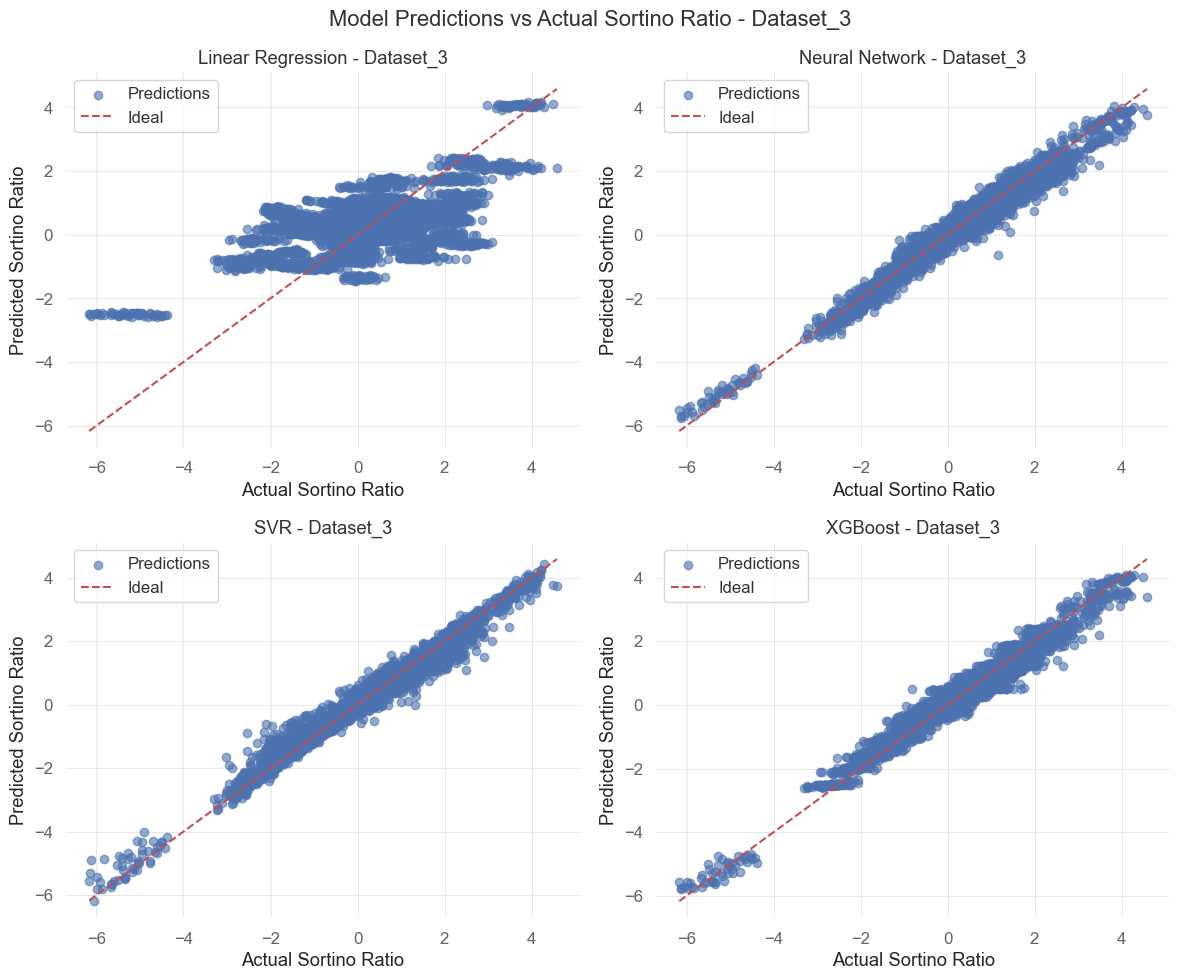

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from Classes import LinearRegressionModel, NeuralNetworkModel, SVRModel, XGBoostModel
from sklearn.preprocessing import StandardScaler

dataset_paths = [
    "dbs/sampled_data_sortino1_mc.csv",
    "dbs/sampled_data_sortino2_mc.csv",
    "dbs/sampled_data_sortino3_mc.csv"
]

# Load and split data
def load_and_split_data(file_path):
    df = pd.read_csv(file_path).drop(columns=['Portfolio_Returns', 'Unnamed: 0', 'Date'])
    
    # Split into features (X) and target (y)
    X = df.drop(columns='Sortino_Ratio')
    y = df['Sortino_Ratio']   # Last column (Sortino Ratio)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into train (70%), validation (15%), and test (15%)
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

def train_models(X_train, y_train, X_val, y_val, dataset_name):
    models = {}

    print("Training Linear Regression Model...")
    lr_model = LinearRegressionModel()
    lr_model.fit(X_train, y_train)
    lr_model.evaluate(X_val, y_val)
    models["Linear Regression"] = lr_model

    print("\nTraining Neural Network Model...")
    nn_model = NeuralNetworkModel(input_dim=X_train.shape[1])
    nn_model.fit(X_train, y_train)
    nn_model.evaluate(X_val, y_val)
    models["Neural Network"] = nn_model

    print("\nTraining SVR Model...")
    svr_model = SVRModel()
    svr_model.fit(X_train, y_train)
    svr_model.evaluate(X_val, y_val)
    models["SVR"] = svr_model

    print("\nTraining XGBoost Model...")
    xgb_model = XGBoostModel()
    xgb_model.fit(X_train, y_train)
    xgb_model.evaluate(X_val, y_val)
    models["XGBoost"] = xgb_model

    # Save models using pickle
    for model_name, model in models.items():
        with open(f"{dataset_name}_{model_name}_mc.pkl", "wb") as f:
            pickle.dump(model, f)
        print(f"Saved {model_name} model to {dataset_name}_{model_name}_mc.pkl")

    return models

# Function to plot model results
def plot_model_results(models, X_test, y_test, dataset_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for ax, (name, model) in zip(axes, models.items()):
        preds = model.predict(X_test)
        ax.scatter(y_test, preds, alpha=0.6, label='Predictions')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
        ax.set_xlabel("Actual Sortino Ratio")
        ax.set_ylabel("Predicted Sortino Ratio")
        ax.set_title(f"{name} - {dataset_name}")
        ax.legend()

    plt.suptitle(f"Model Predictions vs Actual Sortino Ratio - {dataset_name}")
    plt.tight_layout()
    plt.show()

# Main function to process each dataset individually
def main():
    for i, dataset_path in enumerate(dataset_paths):
        dataset_name = f"Dataset_{i+1}"

        print(f"\nProcessing {dataset_name}...\n")
        X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(dataset_path)

        models = train_models(X_train, y_train, X_val, y_val, dataset_name)

        print(f"\nFinal evaluation on test set for {dataset_name}:")
        for name, model in models.items():
            print(f"\n{name} Model:")
            model.evaluate(X_test, y_test)

        plot_model_results(models, X_test, y_test, dataset_name)

if __name__ == "__main__":
    main()


2025-04-10 20:51:33.690331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Processing Dataset_1...


Training XGBoost Model...
 XGBoost optimizado entrenado con éxito.
Evaluation -- MSE: 1.2798, R2: 0.9492
Saved XGBoost model to Dataset_1_XGBoost_mc.pkl

Final evaluation on test set for Dataset_1:

XGBoost Model:
Evaluation -- MSE: 1.3145, R2: 0.9497


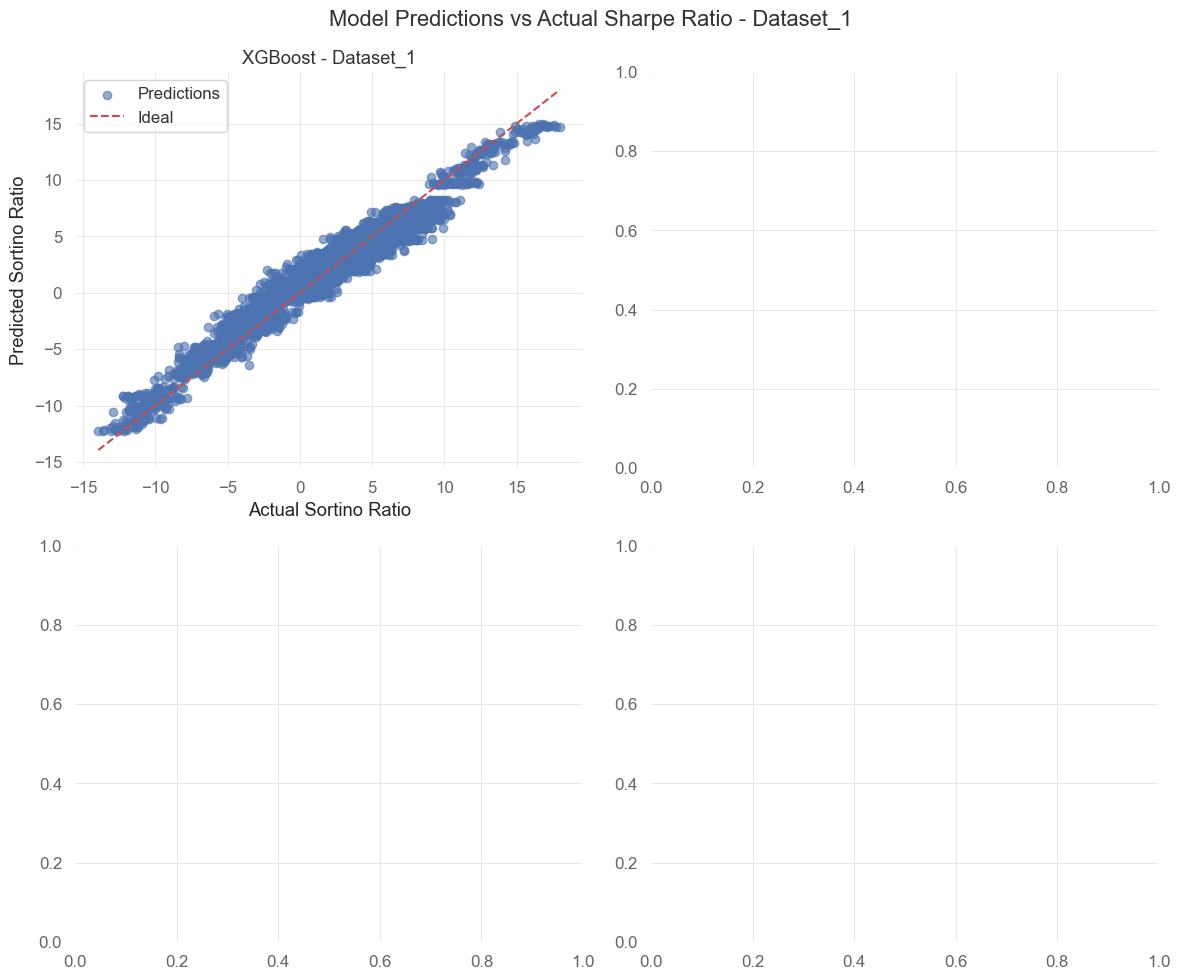


Processing Dataset_2...


Training XGBoost Model...
 XGBoost optimizado entrenado con éxito.
Evaluation -- MSE: 1.3324, R2: 0.9609
Saved XGBoost model to Dataset_2_XGBoost_mc.pkl

Final evaluation on test set for Dataset_2:

XGBoost Model:
Evaluation -- MSE: 1.3680, R2: 0.9597


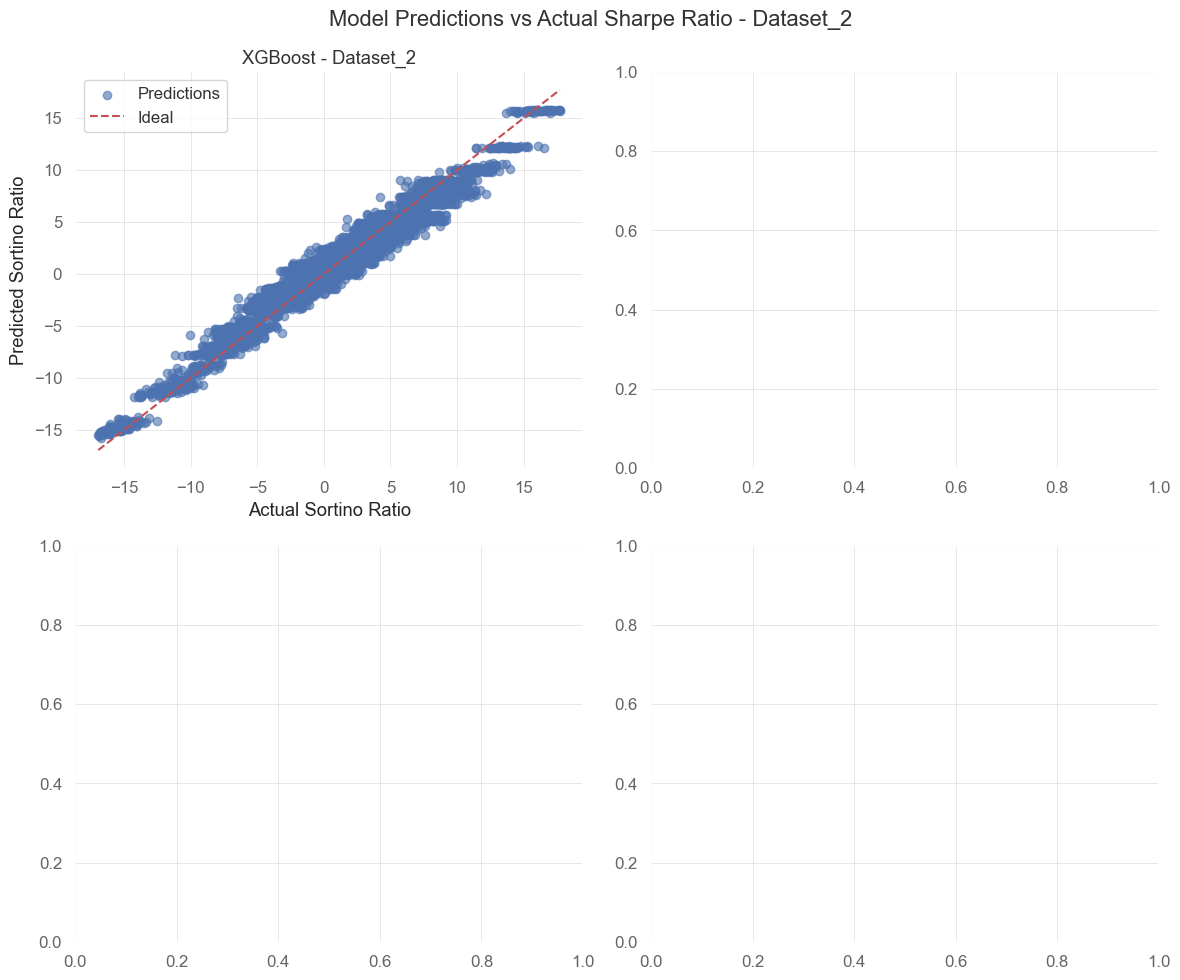


Processing Dataset_3...


Training XGBoost Model...
 XGBoost optimizado entrenado con éxito.
Evaluation -- MSE: 1.2702, R2: 0.9582
Saved XGBoost model to Dataset_3_XGBoost_mc.pkl

Final evaluation on test set for Dataset_3:

XGBoost Model:
Evaluation -- MSE: 1.2435, R2: 0.9591


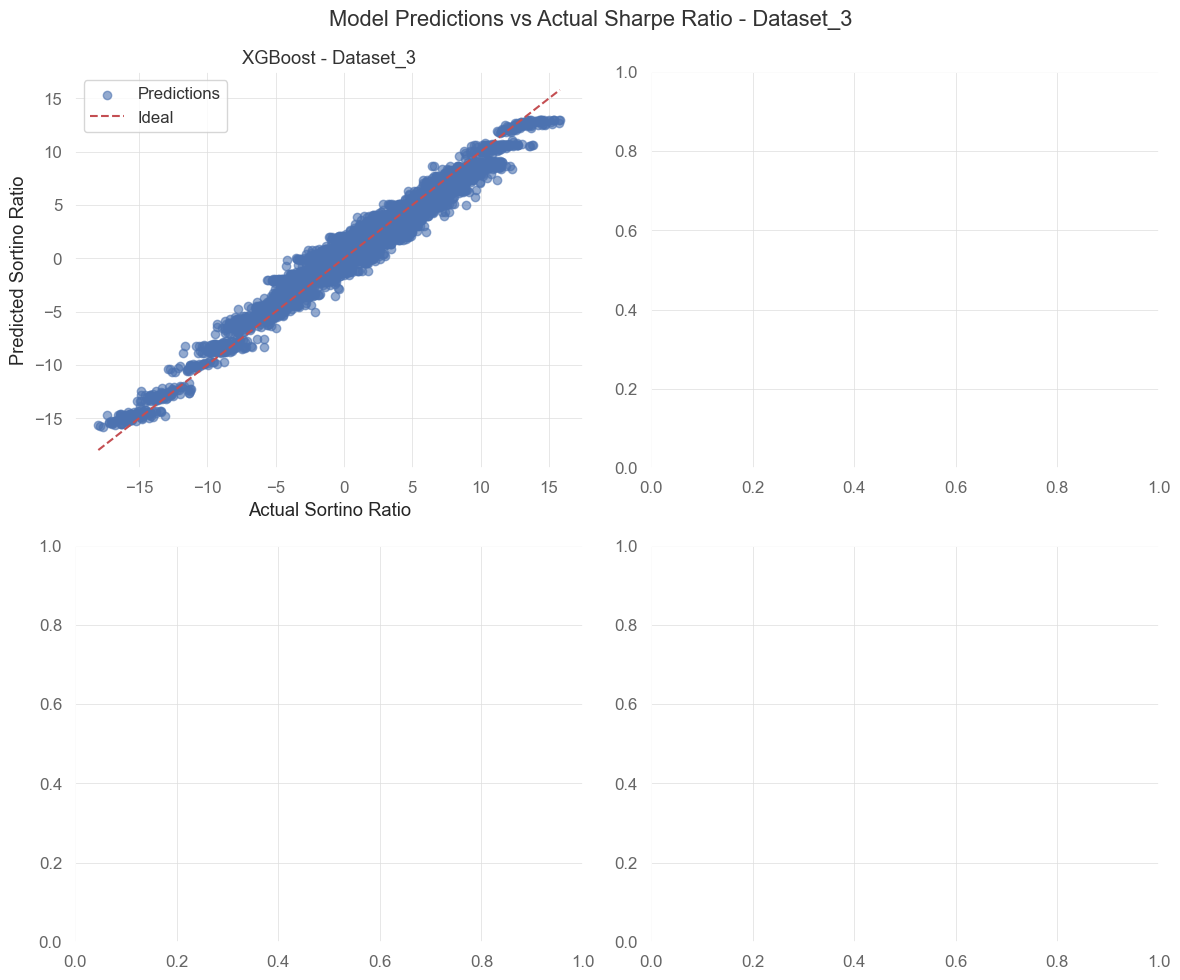

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from Classes import XGBoostModel
from sklearn.preprocessing import StandardScaler

dataset_paths = [
    "dbs/sampled_data_sharpe1_mc.csv",
    "dbs/sampled_data_sharpe2_mc.csv",
    "dbs/sampled_data_sharpe3_mc.csv"
]

# Load and split data
def load_and_split_data(file_path):
    df = pd.read_csv(file_path).drop(columns=['Portfolio_Returns', 'Unnamed: 0', 'Date'])
    
    # Split into features (X) and target (y)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into train (70%), validation (15%), and test (15%)
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

def train_models(X_train, y_train, X_val, y_val, dataset_name):
    models = {}

    print("\nTraining XGBoost Model...")
    xgb_model = XGBoostModel()
    xgb_model.fit(X_train, y_train)
    xgb_model.evaluate(X_val, y_val)
    models["XGBoost"] = xgb_model

    # Save models using pickle
    for model_name, model in models.items():
        with open(f"{dataset_name}_{model_name}_mc.pkl", "wb") as f:
            pickle.dump(model, f)
        print(f"Saved {model_name} model to {dataset_name}_{model_name}_mc.pkl")

    return models

# Function to plot model results
def plot_model_results(models, X_test, y_test, dataset_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for ax, (name, model) in zip(axes, models.items()):
        preds = model.predict(X_test)
        ax.scatter(y_test, preds, alpha=0.6, label='Predictions')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
        ax.set_xlabel("Actual Sortino Ratio")
        ax.set_ylabel("Predicted Sortino Ratio")
        ax.set_title(f"{name} - {dataset_name}")
        ax.legend()

    plt.suptitle(f"Model Predictions vs Actual Sharpe Ratio - {dataset_name}")
    plt.tight_layout()
    plt.show()

# Main function to process each dataset individually
def main():
    for i, dataset_path in enumerate(dataset_paths):
        dataset_name = f"Dataset_{i+1}"

        print(f"\nProcessing {dataset_name}...\n")
        X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(dataset_path)

        models = train_models(X_train, y_train, X_val, y_val, dataset_name)

        print(f"\nFinal evaluation on test set for {dataset_name}:")
        for name, model in models.items():
            print(f"\n{name} Model:")
            model.evaluate(X_test, y_test)

        plot_model_results(models, X_test, y_test, dataset_name)

if __name__ == "__main__":
    main()
